In [10]:
import time
import numpy as np
import nmrglue as ng
import MRAi_2D as ma
import Proc_2D as pr
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':25})

In [11]:
%%time
spectrum = "Malt.ft2"
dic , Ref = ng.pipe.read("Spectra/"+spectrum)
Echo = pr.convertors.VE_to_E(Ref)
Anti = pr.convertors.VE_to_AE(Ref)
np.random.seed(0)
ind_NUS = pr.NUS_sampler.NS(64,128,"PG")
NUS = pr.convertors.US_to_NUS(Ref,ind_NUS)

CPU times: user 85.3 ms, sys: 48 μs, total: 85.3 ms
Wall time: 85.4 ms


In [12]:
%%time
DNN_dirc = "Trained_NN/Echo/"

WNN_Echo_Un = ma.Production.Uncertainty(Echo,DNN_dirc+"Un_WNN/")
WNN_Anti_Un = pr.convertors.flip(ma.Production.Uncertainty(pr.convertors.flip(Anti),DNN_dirc+"Un_WNN/"))
CS_Echo_Un = ma.Production.Uncertainty(Echo,DNN_dirc+"Un_CS/")
CS_Anti_Un = pr.convertors.flip(ma.Production.Uncertainty(pr.convertors.flip(Anti),DNN_dirc+"Un_CS/"))
CS_NUS_Un = ma.Production.Uncertainty(NUS,DNN_dirc+"Un_CS_NUS/")

4/4 [==============================] - 0s 7ms/step
CPU times: user 3.2 s, sys: 285 ms, total: 3.48 s
Wall time: 3.34 s


In [13]:
%%time
WNN_Echo = ma.Production.Echo_Rec(Echo,DNN_dirc+"EAE/")
WNN_Anti = pr.convertors.flip(ma.Production.Echo_Rec(pr.convertors.flip(Anti),DNN_dirc+"EAE/"))
CS_Echo = pr.CS.E_US(Echo,200)
CS_Anti = pr.convertors.flip(pr.CS.E_US(pr.convertors.flip(Anti),200))
CS_NUS = pr.CS.NUS_US(NUS,ind_NUS,200)

4/4 [==============================] - 0s 7ms/step
CPU times: user 30min 20s, sys: 1min 4s, total: 31min 25s
Wall time: 26.4 s


In [14]:
%%time
limits = {"Ubi.ft2": [800, 1500],"Azurin.ft2": [250, 1800],"Tau.ft2": [1100, 1330],
          "Malt.ft2": [100, 800],"Data.ft2":[1,4096]}
limit = limits.get(spectrum)
dic_EX , Ref_R = ng.process.pipe_proc.ext(dic.copy(), Ref, x1= limit[0] , xn= limit[1])

dic_EX , WNN_Echo_R = ng.process.pipe_proc.ext(dic.copy(), WNN_Echo, x1= limit[0] , xn= limit[1])
dic_EX , WNN_Anti_R = ng.process.pipe_proc.ext(dic.copy(), WNN_Anti, x1= limit[0] , xn= limit[1])
dic_EX , WNN_Echo_Un_R = ng.process.pipe_proc.ext(dic.copy(), WNN_Echo_Un, x1= limit[0] , xn= limit[1])
dic_EX , WNN_Anti_Un_R = ng.process.pipe_proc.ext(dic.copy(), WNN_Anti_Un, x1= limit[0] , xn= limit[1])

dic_EX , CS_Echo_R = ng.process.pipe_proc.ext(dic.copy(), CS_Echo, x1= limit[0] , xn= limit[1])
dic_EX , CS_Anti_R = ng.process.pipe_proc.ext(dic.copy(), CS_Anti, x1= limit[0] , xn= limit[1])
dic_EX , CS_Echo_Un_R = ng.process.pipe_proc.ext(dic.copy(), CS_Echo_Un, x1= limit[0] , xn= limit[1])
dic_EX , CS_Anti_Un_R = ng.process.pipe_proc.ext(dic.copy(), CS_Anti_Un, x1= limit[0] , xn= limit[1])

dic_EX , CS_NUS_R = ng.process.pipe_proc.ext(dic.copy(), CS_NUS, x1= limit[0] , xn= limit[1])
dic_EX , CS_NUS_Un_R = ng.process.pipe_proc.ext(dic.copy(), CS_NUS_Un, x1= limit[0] , xn= limit[1])


CPU times: user 427 ms, sys: 8.38 ms, total: 436 ms
Wall time: 4.59 ms


CPU times: user 15.7 s, sys: 577 ms, total: 16.3 s
Wall time: 1.3 s


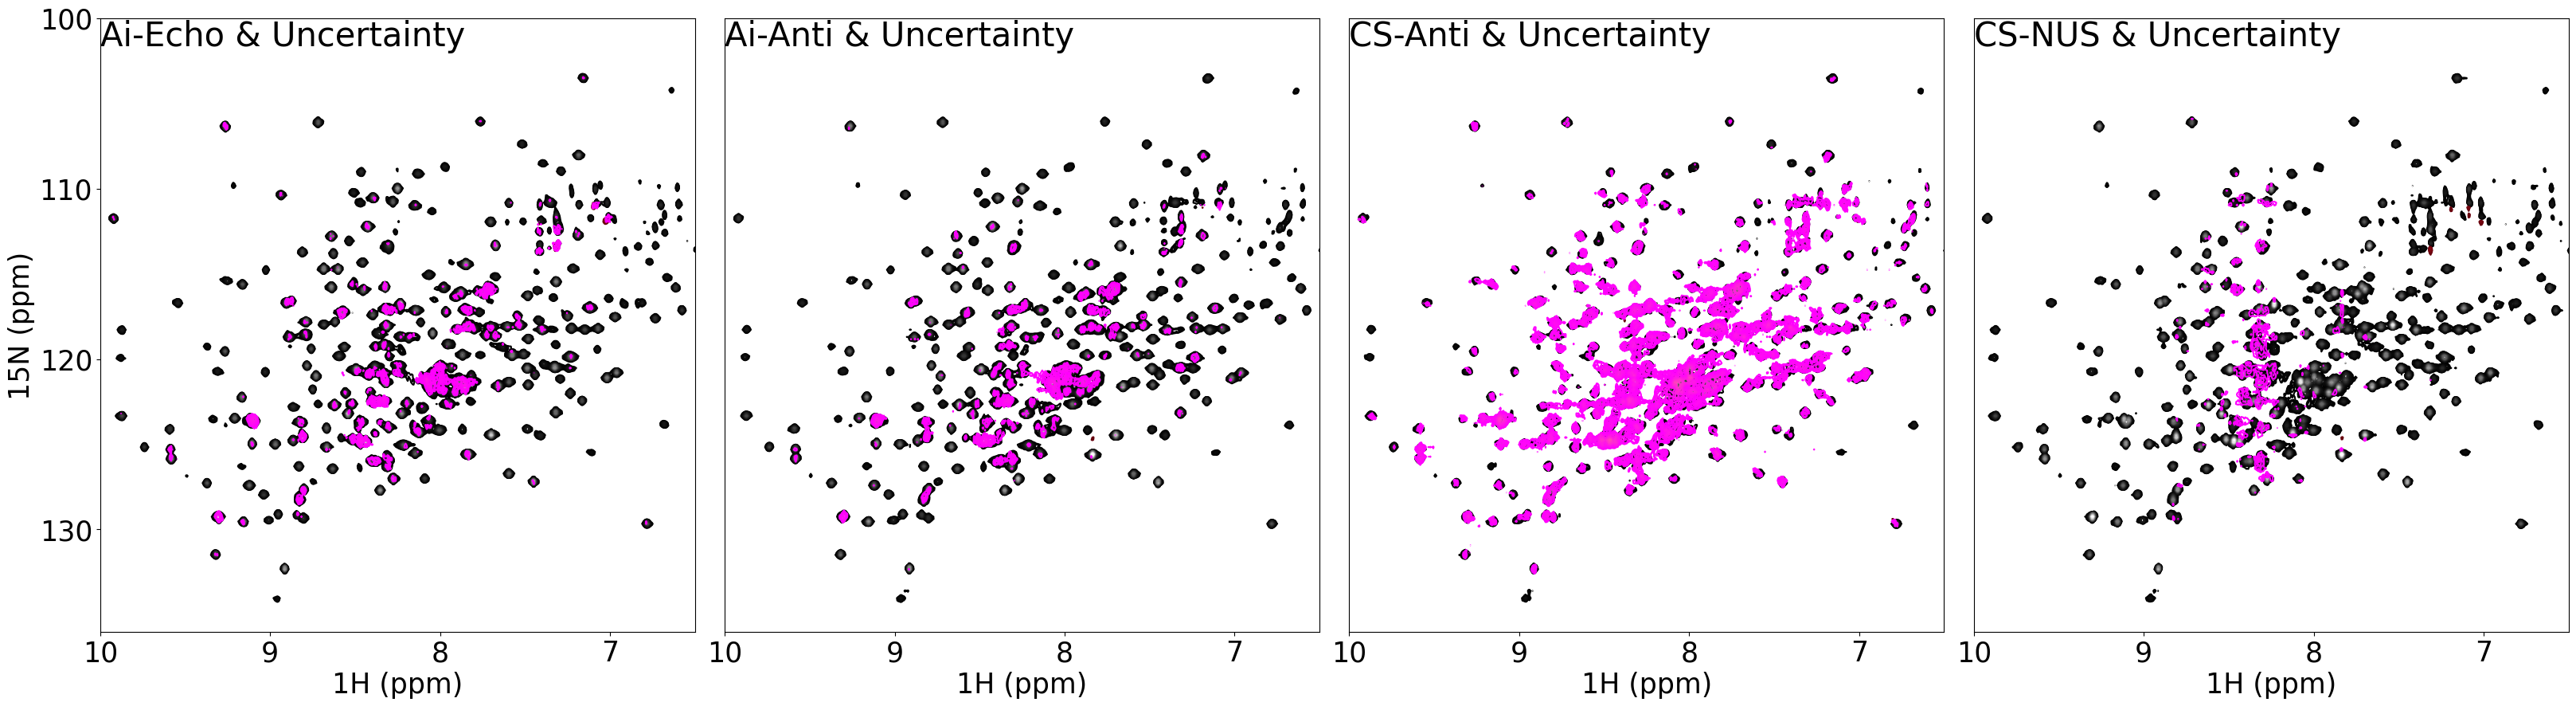

In [15]:
%%time
contours = {"Ubi.ft2": [0.03,1.2,20] ,"Azurin.ft2": [0.02,1.2,20],"Tau.ft2": [0.04,1.2,20],
            "Malt.ft2": [0.025,1.2,20],"Data.ft2": [0.02,1.2,20]}
lims = {"Ubi.ft2": [9.9,6,130,100],"Azurin.ft2": [10,5.6,135,100],"Tau.ft2": [8.5, 7.6,130, 105],
        "Malt.ft2": [10, 6.5,136, 100],"Data.ft2": [12.7,-3.3,138,98]}

fig, ax = plt.subplots(1,4,figsize=(4*10,10))
cmap = [plt.cm.Greys_r,plt.cm.Reds_r]    #[+,-] contour map (colors to use for contours)
contour = contours.get(spectrum)         #[contour level start value, scaling factor between contour level]
lim = lims.get(spectrum) 

pr.PLOTS.subp(ax[0],dic,WNN_Echo/np.max(Ref), "Ai-Echo & Uncertainty",
     contour,cmap,lim,2*WNN_Echo_Un/np.max(Ref),plt.cm.spring)

pr.PLOTS.subp(ax[1],dic,WNN_Anti/np.max(Ref), "Ai-Anti & Uncertainty",
      contour,cmap,lim,2*WNN_Anti_Un/np.max(Ref),plt.cm.spring)

pr.PLOTS.subp(ax[2],dic,CS_Anti/np.max(Ref),"CS-Anti & Uncertainty",
      contour,cmap,lim,2*CS_Anti_Un/np.max(Ref),plt.cm.spring)

pr.PLOTS.subp(ax[3],dic,CS_NUS/np.max(Ref),"CS-NUS & Uncertainty",
      contour,cmap,lim,4*CS_NUS_Un/np.max(Ref),plt.cm.spring)

ax[1].axes.yaxis.set_visible(False)
ax[2].axes.yaxis.set_visible(False)
ax[3].axes.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

CPU times: user 26.3 ms, sys: 7.94 ms, total: 34.2 ms
Wall time: 32.4 ms


[Text(0, 0.5, '$\\sigma/S_{p_{max}}$')]

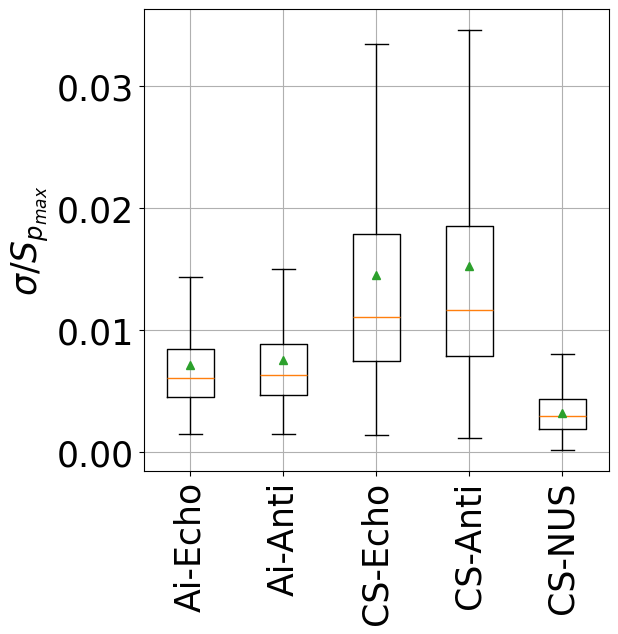

In [16]:
%%time
def Selected_Un(Uncer,Pred,Noise_threshold,RMSD_threshold=1):
    U = Uncer.flatten()/np.max(Pred)
    P = Pred.flatten()/np.max(Pred)
    return U[(np.abs(P)>Noise_threshold) & (np.abs(P)<=RMSD_threshold)]

threshold = 0.01
threshold_up = 1

Label = ['Ai-Echo','Ai-Anti','CS-Echo','CS-Anti','CS-NUS']

fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.boxplot([Selected_Un(WNN_Echo_Un_R,WNN_Echo_R,threshold,threshold_up),
           Selected_Un(WNN_Anti_Un_R,WNN_Anti_R,threshold,threshold_up),
           Selected_Un(CS_Echo_Un_R,CS_Echo_R,threshold,threshold_up),
           Selected_Un(CS_Anti_Un_R,CS_Anti_R,threshold,threshold_up),
           Selected_Un(CS_NUS_Un_R,CS_NUS_R,threshold,threshold_up)],
           showfliers=False, showmeans=True)
ax.locator_params(axis="y", nbins=4)
ax.tick_params(axis='x', labelrotation = 90)
ax.set_xticklabels(Label)
ax.grid()
ax.set(ylabel='$\sigma/S_{p_{max}}$')

CPU times: user 2.77 s, sys: 153 ms, total: 2.93 s
Wall time: 32.4 ms


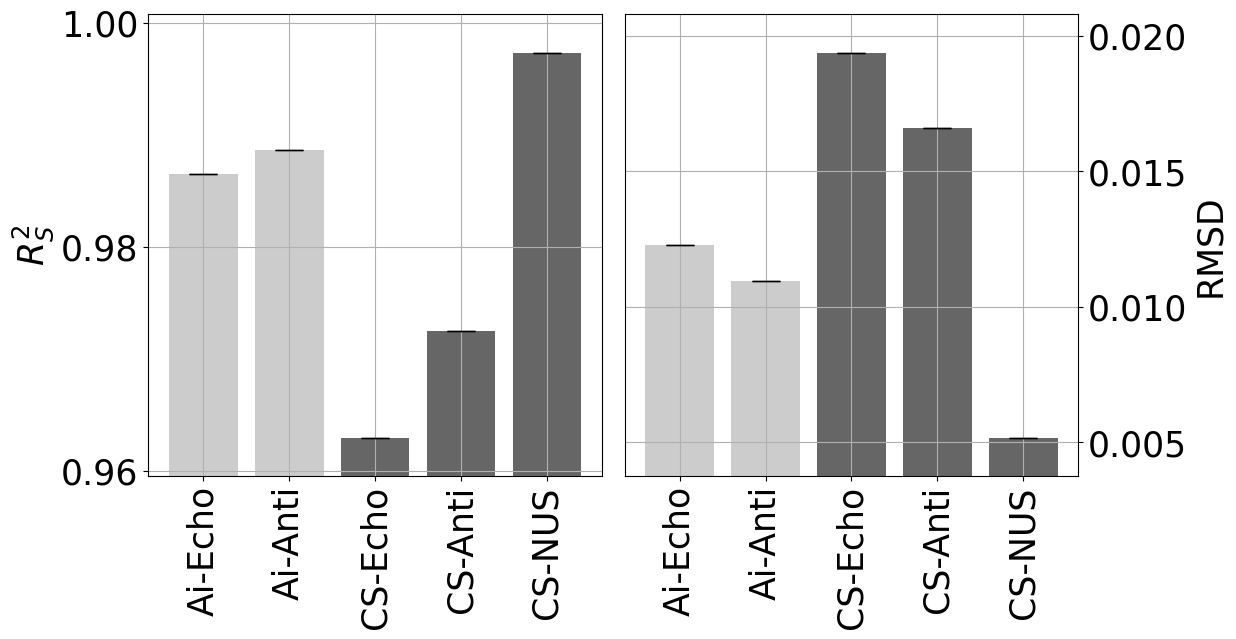

In [17]:
%%time
threshold = 0.01
threshold_up = 1
RR_U = np.zeros((5,1))
RMSD_U = np.zeros((5,1))
for j in range(1):
    RR_U[0,j], RMSD_U[0,j] = pr.metric.CC_RMSD(Ref_R,WNN_Echo_R,threshold,threshold_up)
    RR_U[1,j], RMSD_U[1,j] = pr.metric.CC_RMSD(Ref_R,WNN_Anti_R,threshold,threshold_up)
    RR_U[2,j], RMSD_U[2,j] = pr.metric.CC_RMSD(Ref_R,CS_Echo_R,threshold,threshold_up)
    RR_U[3,j], RMSD_U[3,j] = pr.metric.CC_RMSD(Ref_R,CS_Anti_R,threshold,threshold_up)
    RR_U[4,j], RMSD_U[4,j] = pr.metric.CC_RMSD(Ref_R,CS_NUS_R,threshold,threshold_up)

Label = ['Ai-Echo','Ai-Anti','CS-Echo','CS-Anti','CS-NUS']
color = ['0.8','0.8','0.4','0.4','0.4']    

pr.PLOTS.CC_RMSD_plt(Label,RR_U,RMSD_U,color)

CPU times: user 2.69 s, sys: 66.2 ms, total: 2.76 s
Wall time: 1.3 s


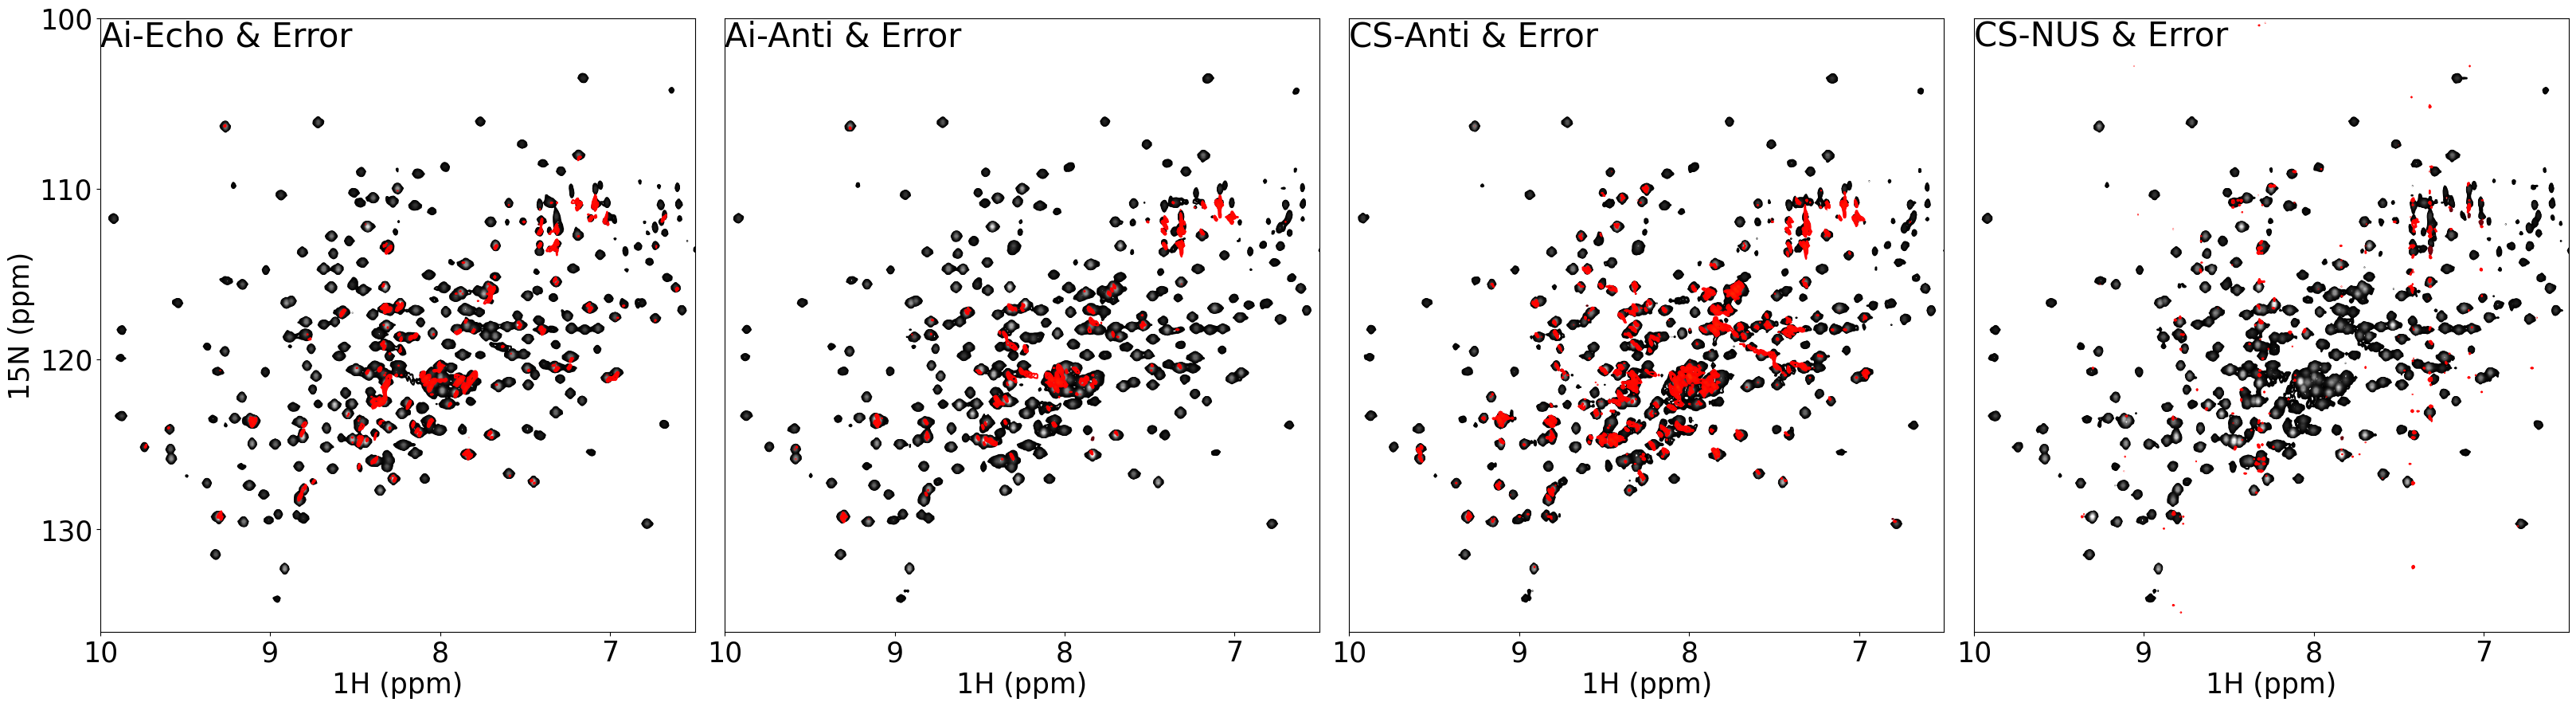

In [18]:
%%time
fig, ax = plt.subplots(1,4,figsize=(4*10,10))

pr.PLOTS.subp(ax[0],dic,WNN_Echo/np.max(Ref), "Ai-Echo & Error",
     contour,cmap,lim,np.abs(WNN_Echo-Ref)/np.max(Ref),plt.cm.autumn)

pr.PLOTS.subp(ax[1],dic,WNN_Anti/np.max(Ref), "Ai-Anti & Error",
     contour,cmap,lim,np.abs(WNN_Anti-Ref)/np.max(Ref),plt.cm.autumn)

pr.PLOTS.subp(ax[2],dic,CS_Anti/np.max(Ref), "CS-Anti & Error",
     contour,cmap,lim,np.abs(CS_Anti-Ref)/np.max(Ref),plt.cm.autumn)

pr.PLOTS.subp(ax[3],dic,CS_NUS/np.max(Ref), "CS-NUS & Error",
     contour,cmap,lim,2*np.abs(CS_NUS-Ref)/np.max(Ref),plt.cm.autumn)

ax[1].axes.yaxis.set_visible(False)
ax[2].axes.yaxis.set_visible(False)
ax[3].axes.yaxis.set_visible(False)


plt.subplots_adjust(wspace=0.05, hspace=0.05)